In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import train_test_split

import sys
sys.path.append('../../../scripts/')
from PreparaDatasetV2 import *

# Parâmetros do método

In [2]:
TARGET = 'Back_HA_Home'
ODDS = 'HA_Odds_H'

# Carregando o dataset

In [3]:
data = pd.read_csv('../../../data/Entire_Season.csv')
data = prepara_df(data)

In [4]:
def prepara_dataset(_df):

    _df = _df[_df['HA_Line'] < 0]

    _df.loc[((_df['Home_Pts'] + _df['HA_Line']) > _df['Away_Pts']), 'Back_HA_Home'] = 1
    _df.loc[((_df['Home_Pts'] + _df['HA_Line']) < _df['Away_Pts']), 'Back_HA_Home'] = 0

    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    # _df.dropna(subset=['Avg_CG_H', 'Avg_CG_A', TARGET], inplace=True)

    _df.reset_index(drop=True, inplace=True)

    return _df

In [5]:
df = data.copy()
df = prepara_dataset(df)

In [6]:
treinamento, val = train_test_split(df, train_size=0.66, random_state=150)
real_treino, real_teste = train_test_split(treinamento, train_size=0.5, random_state=150)

print(f'Treino: {real_treino.shape[0]} | Teste: {real_teste.shape[0]} | Validação: {val.shape[0]}')

Treino: 1736 | Teste: 1737 | Validação: 1790


# Criação do modelo

In [192]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Avg_CG_H',
       'DP_CG_H', 'CV_CG_H', 'Avg_Pontos_H', 'DP_Pontos_H', 'CV_Pontos_H',
       'CG_H_Last_Game', 'Media_Odds_Geral_H', 'DP_Odds_Geral_H',
       'CV_Odds_Geral_H', 'Saldo_Gols_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A',
       'Avg_Pontos_A', 'DP_Pontos_A', 'CV_Pontos_A', 'CG_A_Last_Game',
       'Media_Odds_Geral_A', 'DP_Odds_Geral_A', 'CV_Odds_Geral_A',
       'Saldo_Gols_A', 'Goals_Last_H', 'Goals_Last_A', 'Last_Odd_H',
       'Last_Odd_A', 'MediaCustoGolHome', 'MediaCustoGolAway', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH',
       'Custo_Retorno_BH', 'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real',
       'Dist_Porc_BH', 'Retornos_BA_Acu', 'Avg_Retornos_BA',
       'Custo_Retorno_BA', 'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real',
       'Dist_Porc_BA']

features = ['Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff',
       'CG_H_Last_Game', 'CG_A_Last_Game', 'Goals_Last_H', 'Goals_Last_A', 'Last_Odd_H',
       'Last_Odd_A', 'CV_ML',
       'CV_Over', 'CV_HA', ]

In [219]:
# Ranges da variável
ranges_dict['P(A)']['range']

Interval(0.275, 0.351, closed='right')

In [220]:
def filtra_resultados(_df, filtro = 0):

    if filtro == 1:
        _df = _df[((_df['CG_A_Last_Game'] < 154)) | ((_df['CG_A_Last_Game'] > 214.5))]
        _df = _df[((_df['CV_Over'] > 0.00773))]
        _df = _df[((_df['P(A)'] < 0.275)) | ((_df['P(A)'] > 0.351))]

    return _df

In [194]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = {
            'pl': plb,
            'wr': wr,
            'oddback': oddback,
            'med_gain': med_gain,
            'med_loss': med_loss,
            'roi': roi,
            'porc_ent': porc_ent,
            'ev': ev,
        }
        return metrics

def exibe_grafico(_df, per_day = False):
    _df.sort_index(inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        
        _df['Date'] = pd.to_datetime(_df['Date'])
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def info_modelo(data, stake = 1, filtro = 0, per_day = False):
    total = data.shape[0]

    _df = filtra_resultados(data, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df, per_day)
    
    return _df


PL: 12.14 | ROI: 6.07% | Prec.: 0.54
Odd média: 1.99 (0.50 WR)
Média Gain: 0.98 | Média Loss: -1.00
EM: 0.07
200 entradas em 1736 jogos (11.52%)


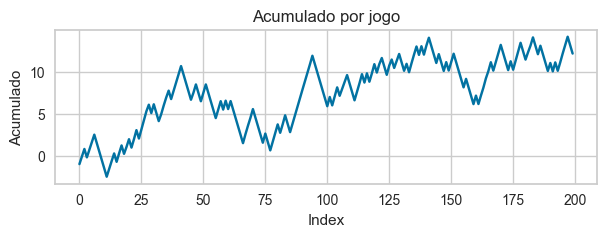

PL: 1.02 | ROI: 0.50% | Prec.: 0.50
Odd média: 2.00 (0.50 WR)
Média Gain: 0.99 | Média Loss: -1.00
EM: -0.00
202 entradas em 1737 jogos (11.63%)


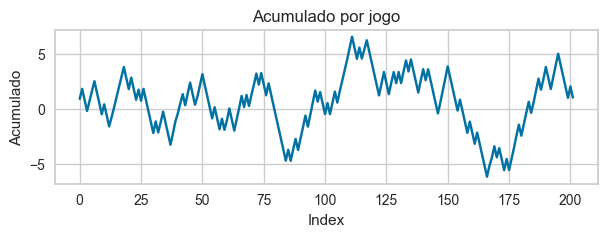

PL: 13.16 | ROI: 3.27% | Prec.: 0.52
Odd média: 2.00 (0.50 WR)
Média Gain: 0.99 | Média Loss: -1.00
EM: 0.03
402 entradas em 3473 jogos (11.58%)


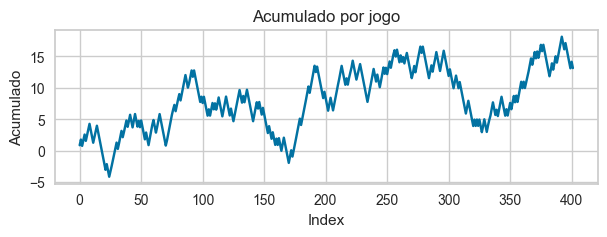

In [221]:
flt = 1

df_treino = info_modelo(real_treino, filtro = flt)
df_teste = info_modelo(real_teste, filtro = flt)
df_treinamento = info_modelo(treinamento, filtro = flt)

PL: -207.23 | ROI: -11.58% | Prec.: 0.46
Odd média: 1.93 (0.52 WR)
Média Gain: 0.93 | Média Loss: -1.00
EM: -0.11
1790 entradas em 1790 jogos (100.00%)


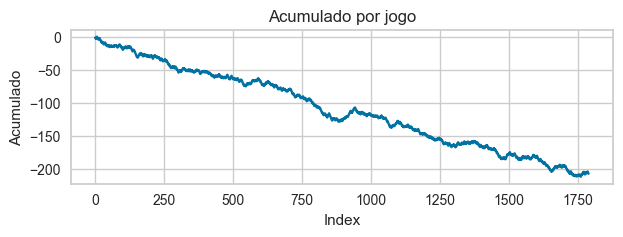

In [196]:
df_val = info_modelo(val, filtro = flt)

In [ ]:
plt.axvline(x=len(pd.concat([df_treino, df_teste])), color='green', linestyle='--')
comp = pd.concat([df_treino, df_teste, df_val])
exibe_metricas(comp, total=len(treinamento) + len(val))
exibe_grafico(comp)

# QCut automático

In [178]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_top_range(var, treino, teste, validacao, ratio = 3):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    var_dict['range'] = ranges
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict


def find_neg_range(var, treino, teste, validacao):
    nome = f'Cat_{var}'
    var_dict = {}

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]
    
    metric_val = {}

    metric_treino = exibe_metricas(treino_filtrado, total=len(real_treino), return_metrics=True)
    metric_teste = exibe_metricas(teste_filtrado, total=len(real_teste), return_metrics=True)
    metric_val = exibe_metricas(val_filtrado, total=len(val), return_metrics=True)

    var_dict['range'] = range
    var_dict['metric_treino'] = metric_treino
    var_dict['metric_teste'] = metric_teste
    var_dict['metric_val'] = metric_val

    return var_dict

In [222]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

In [223]:
variaveis = features.copy()
ranges_dict = {}

for var in variaveis:
    try:
        # new_dict = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.0)
        new_dict = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val)
        # new_dict = find_top_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 3)
        ranges_dict[var] = new_dict
    except:
        pass

In [224]:
for var in ranges_dict:
    print(f'{var}')
    print(f'ROI treino: {ranges_dict[var]["metric_treino"]["roi"]:.2f}')
    print(f'ROI teste: {ranges_dict[var]["metric_teste"]["roi"]:.2f}')
    print(f'ROI val: {ranges_dict[var]["metric_val"]["roi"]:.2f}')
    print(f'% Ent: {ranges_dict[var]["metric_treino"]["porc_ent"]:.2f}')
    print()

Odds_Over
ROI treino: 0.08
ROI teste: 0.03
ROI val: -0.11
% Ent: 0.09

Odds_Under
ROI treino: 0.03
ROI teste: 0.02
ROI val: -0.12
% Ent: 0.10

HA_Line
ROI treino: 0.06
ROI teste: 0.05
ROI val: -0.13
% Ent: 0.09

HA_Odds_H
ROI treino: 0.05
ROI teste: 0.09
ROI val: -0.12
% Ent: 0.09

HA_Odds_A
ROI treino: 0.06
ROI teste: 0.07
ROI val: -0.11
% Ent: 0.09

P(H)
ROI treino: 0.05
ROI teste: 0.02
ROI val: -0.12
% Ent: 0.10

P(A)
ROI treino: 0.05
ROI teste: 0.04
ROI val: -0.11
% Ent: 0.10

P(O)
ROI treino: 0.11
ROI teste: 0.02
ROI val: -0.11
% Ent: 0.10

P(U)
ROI treino: 0.04
ROI teste: 0.06
ROI val: -0.12
% Ent: 0.09

P_Diff
ROI treino: 0.06
ROI teste: 0.04
ROI val: -0.11
% Ent: 0.09

CG_H_Last_Game
ROI treino: -0.26
ROI teste: 0.07
ROI val: -0.12
% Ent: 0.02

CG_A_Last_Game
ROI treino: 0.13
ROI teste: 0.01
ROI val: -0.12
% Ent: 0.09

Goals_Last_H
ROI treino: 0.10
ROI teste: 0.04
ROI val: -0.12
% Ent: 0.09

Goals_Last_A
ROI treino: 0.08
ROI teste: 0.05
ROI val: -0.12
% Ent: 0.10

Last_Odd_H
RO

# Script qcut

In [125]:
# df_cut1 = df_treino.copy()
df_cut = df_treinamento.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [126]:
variaveis = features.copy()

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 5)

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

Odds_H
                             sum             count     ratio
               PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_H                                                  
(-0.001, 1.18]            -76.22               717 -0.106304
(1.18, 1.33]              -91.56               709 -0.129140
(1.33, 1.5]               -26.82               737 -0.036391
(1.5, 1.68]               -57.47               654 -0.087875
(1.68, 4.5]               -67.03               656 -0.102180




------------------------------------------------



Odds_A
                            sum             count     ratio
              PL_BF_Predictions PL_BF_Predictions          
Cat_Odds_A                                                 
(-0.001, 2.2]            -69.48               697 -0.099684
(2.2, 2.7]               -37.74               788 -0.047893
(2.7, 3.35]              -47.38               608 -0.077928
(3.35, 4.89]             -86.44               686 -0.126006
(4.89, 40.0]          